In [1]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from datasets import load_dataset

# Example: Loading the IMDB dataset
data = load_dataset("lavita/medical-qa-datasets", 'all-processed')
data = data['train'].train_test_split(test_size=0.2)

In [5]:
train_data = data['train']
val_data = data['test']

In [6]:
print("Number of entries:", len(train_data))
print("Example entry:\n", train_data[50])

Number of entries: 191485
Example entry:
 {'instruction': 'Please summerize the given abstract to a title', 'input': 'The agencies of the government of the United States of America, such as the Food and Drug Administration or the Environmental Protection Agency, intervene in American society through the collection, processing, and diffusion of information. The Presidency of Barack Obama was notable for updating and redesigning the US government’s information infrastructure. The White House enhanced mass consultation through open government and big data initiatives to evaluate policy effectiveness, and it launched new ways of communicating with the citizenry. In this essay we argue that these programs spelled out an emergent epistemology based on two assumptions: dispersed knowledge and a critique of judgment. These programs have redefined the evidence required to justify and design regulatory policy and conferred authority to a new kind of expert, which we call epistemic consultants.',

In [7]:
print("Another example entry:\n", train_data[999])

Another example entry:
 {'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.", 'input': 'I am a female 53 yr old woman. ,5 6 137 lbs. I have a bilateral maxillary cyst 1.4cc on left side of sinus and 1.2cc on right side of sinus. My white blood cell count is 3.1 could the cyst cause white blood cells to be low? If not what would it mean?', 'output': 'hit hanks for askingbased on your query and complaints my opinion is1. a low wbc count in your case is not related to cyst.2. there are numerous causes of a low count.3. it can be due to steroid therapy, or certain medications, or bone marrow depression or viral infections.4. get a test to repeat counts after two weeks. if persistently low, get a bone marrow examination done. hope this helpsregards', '__index_level_0__': 136491}


In [8]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [9]:
model_input = format_input(train_data[50])
desired_response = f"\n\n### Response:\n{train_data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Please summerize the given abstract to a title

### Input:
The agencies of the government of the United States of America, such as the Food and Drug Administration or the Environmental Protection Agency, intervene in American society through the collection, processing, and diffusion of information. The Presidency of Barack Obama was notable for updating and redesigning the US government’s information infrastructure. The White House enhanced mass consultation through open government and big data initiatives to evaluate policy effectiveness, and it launched new ways of communicating with the citizenry. In this essay we argue that these programs spelled out an emergent epistemology based on two assumptions: dispersed knowledge and a critique of judgment. These programs have redefined the evidence required to justify and design regulatory policy and conferred authorit

In [10]:
model_input = format_input(train_data[999])
desired_response = f"\n\n### Response:\n{train_data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
I am a female 53 yr old woman. ,5 6 137 lbs. I have a bilateral maxillary cyst 1.4cc on left side of sinus and 1.2cc on right side of sinus. My white blood cell count is 3.1 could the cyst cause white blood cells to be low? If not what would it mean?

### Response:
hit hanks for askingbased on your query and complaints my opinion is1. a low wbc count in your case is not related to cyst.2. there are numerous causes of a low count.3. it can be due to steroid therapy, or certain medications, or bone marrow depression or viral infections.4. get a test to repeat counts after two weeks. if persistently low, get a bone marrow examination done. hope this helpsregards


In [11]:
print("Training set length:", train_data.shape)
print("Validation set length:", val_data.shape)

Training set length: (191485, 4)
Validation set length: (47872, 4)


In [12]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [14]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [16]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [17]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 4

# torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [18]:
!cp /kaggle/input/data-gpt-lat/gpt_download.py /kaggle/working/gpt_download.py
!cp /kaggle/input/data-gpt-lat/utils.py /kaggle/working/utils.py

In [19]:
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt


# BASE_CONFIG = {
#     "vocab_size": 50257,     # Vocabulary size
#     "context_length": 1024,  # Context length
#     "drop_rate": 0.0,        # Dropout rate
#     "qkv_bias": True         # Query-key-value bias
# }

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# CHOOSE_MODEL = "gpt2-large (774M)"
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 36.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.02MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 44.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:26<00:00, 18.9MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.48MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.51MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.47MiB/s]


In [20]:
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer this question truthfully

### Input:
What are the symptoms of Depression in Elderly?


In [21]:
from utils import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [22]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

What are the symptoms of Depression in Elderly?



What are the symptoms of Depression in Elderly?


In [23]:
from utils import (
    calc_loss_loader,
    train_model_simple
)

In [24]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.7833401679992678
Validation loss: 3.6716897010803224


In [25]:
import time

start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=1000, eval_iter=1000,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.506, Val loss 3.507
Ep 1 (Step 001000): Train loss 2.494, Val loss 2.479
Ep 1 (Step 002000): Train loss 2.423, Val loss 2.415
Ep 1 (Step 003000): Train loss 2.398, Val loss 2.377
Ep 1 (Step 004000): Train loss 2.353, Val loss 2.350
Ep 1 (Step 005000): Train loss 2.350, Val loss 2.332
Ep 1 (Step 006000): Train loss 2.313, Val loss 2.311
Ep 1 (Step 007000): Train loss 2.292, Val loss 2.296
Ep 1 (Step 008000): Train loss 2.295, Val loss 2.287
Ep 1 (Step 009000): Train loss 2.255, Val loss 2.270
Ep 1 (Step 010000): Train loss 2.239, Val loss 2.258
Ep 1 (Step 011000): Train loss 2.223, Val loss 2.248
Ep 1 (Step 012000): Train loss 2.227, Val loss 2.241
Ep 1 (Step 013000): Train loss 2.231, Val loss 2.233
Ep 1 (Step 014000): Train loss 2.214, Val loss 2.226
Ep 1 (Step 015000): Train loss 2.206, Val loss 2.218
Ep 1 (Step 016000): Train loss 2.202, Val loss 2.214
Ep 1 (Step 017000): Train loss 2.176, Val loss 2.206
Ep 1 (Step 018000): Train loss 2.184, Val loss

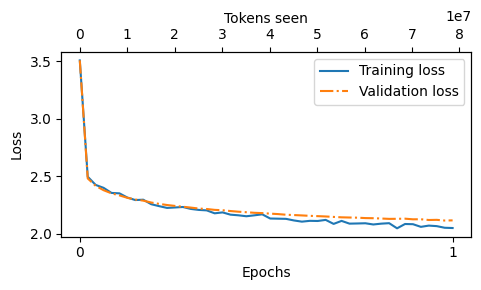

In [26]:
from utils import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [27]:
for i in range(8, 16):

    input_text = format_input(val_data[i])

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {val_data[i]['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
hi, im 19 years .... i cannot retract my foreskin when penis is fully erect but i can do it in flaccid state. However,if id retract it every day for cleaning, that would cause fissures - the foreskin is sticking to the glans, so when it is retracted small pieces of the glans are tearing ... and it even got blood one time.  Please tell me, should i do something different when i retract it ? Is it normal for foreskin to be sticked to the glans ? i am really afraid to retract it, i do it only 1 time per week maximum

Correct response:
>> hi and. i think you are suffering from fibrosis, mitosis is the inability to retract the foreskin behind the glans in males. physiologic fibrosis is the normal condition in which child chatbot. the inability of the foreskin to ret

In [28]:
file_name = "lavita-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as lavita-sft.pth


In [30]:
!cp /kaggle/working/lavita-sft.pth /kaggle/input/data-gpt-lat/

cp: cannot create regular file '/kaggle/input/data-gpt-lat/lavita-sft.pth': Read-only file system


In [38]:
!zip -r zip_folder.zip /kaggle/working/

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/__pycache__/ (stored 0%)
updating: kaggle/working/__pycache__/gpt_download.cpython-310.pyc (deflated 37%)
updating: kaggle/working/__pycache__/utils.cpython-310.pyc (deflated 51%)
updating: kaggle/working/gpt2/ (stored 0%)
updating: kaggle/working/gpt2/124M/ (stored 0%)
updating: kaggle/working/gpt2/124M/hparams.json (deflated 28%)
updating: kaggle/working/gpt2/124M/model.ckpt.data-00000-of-00001 (deflated 7%)
updating: kaggle/working/gpt2/124M/vocab.bpe (deflated 53%)
updating: kaggle/working/gpt2/124M/encoder.json (deflated 67%)
updating: kaggle/working/gpt2/124M/model.ckpt.index (deflated 62%)
updating: kaggle/working/gpt2/124M/model.ckpt.meta (deflated 91%)
updating: kaggle/working/gpt2/124M/checkpoint (deflated 42%)
updating: kaggle/working/gpt_download.py (deflated 66%)
updating: kaggle/working/loss-plot.pdf (deflated 30%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/lavita-sft.pth

In [37]:
data.save_to_disk("/kaggle/working/")

Saving the dataset (0/1 shards):   0%|          | 0/191485 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/47872 [00:00<?, ? examples/s]

In [39]:
from IPython.display import FileLink

In [40]:
FileLink('zip_folder.zip')

/kaggle/working/zip_folder.zip